In [ ]:
#|default_exp virtual_abm

In [ ]:
#| export
import numpy as np

# Virtual environment 
This is a wrapper that merges the forager and agent whose only input is the displacement of a real particle at each step. The output is the action to be taken.

## Wrapper

In [ ]:
#| export
from rl_opts.rl_framework.numba.agents import Forager
from rl_opts.rl_framework.numba.environments import TargetEnv

In [ ]:
#| export
class virtual_ABM:

    def __init__(self, 
                 num_episodes : int = None, # If int, number of episodes. If None, don't consider episodes
                 time_ep : int = None, # If int, length of an episodes. If episodes = None, it is not considered.
                 L : float = 5, # Size of the environment
                 r : float = 1, # Radius of the target       
                 max_counter : int = 500, # Maximum number for the agent's phase counter (i.e. what it gets as station)
                 gamma_damping : float = 0.001, # Gamma of PS
                 eta_glow_damping : float = 0.001, # Glow of PS                 
                 max_no_H_update : int = int(1e4), # maximum number of steps before an update of H and G matrices.
                 Nt :int = 1, # Number of targets
                 g_update : str = 's' # How to update the G matrix. Either 's' for sum or 'r' for replace
                 ):
        
        # Arguments for TargetEnv
        destructive = True
        lc = np.array([[1.0],[1]]) # Won't enter into effect if destructive = True
        lc_distribution = 'constant' # Won't enter into effect if destructive = True
        agent_step = 1

        self.env = TargetEnv(Nt, L, r, lc, agent_step, 1, destructive, lc_distribution)
       
        self.particle_position = self.env.positions[0]

        # Arguments for Forager
        num_actions = 2
        self.max_counter = max_counter
        size_state_space = np.array([2, self.max_counter]) # first is phase (either active or passive). Second is the counter till last change
        policy_type='standard' # Sampling of policy
        beta_softmax=3 # Parameters if policy is softmax
        initial_prob_distr = np.array([[],[]]) # Initial h-matrix
        fixed_policy=np.array([[],[]]) # If considering a fixed policy
        
        self.agent = Forager(num_actions,size_state_space,gamma_damping,
                             eta_glow_damping,policy_type,beta_softmax,
                             initial_prob_distr,fixed_policy,max_no_H_update, g_update) 

    
        
        self.num_episodes = num_episodes
        self.time_ep = time_ep

        self.init_training()
        

    def _particle_position(self):
        return self.env.positions[0]
    def _target_position(self):
        return self.env.target_positions[0] 
    
    def init_training(self):
        ''' Initializes the environment and epochs '''
        self.init_virtual_env()
        
        if self.num_episodes: 
            self.epoch = -1 # we start at -1 because init_epoch will sum one and set it at zero.
            self.init_epoch()

        self.done = False

    def init_virtual_env(self):
        # Current phase is: 0 for passive, 1 for active
        self.current_phase = 0 # Starting always in the passive phase

        # Initialize the environment (puts agent and target in random position)
        self.env.init_env()

        # Initialize / Reset agent's props
        self.agent.agent_state = 0
        self.agent.reset_g()
        self.agent.N_upd_H = 0
        self.agent.N_upd_G = 0

    def init_epoch(self):
        ''' Initializes a new epoch '''
        self.init_virtual_env()
        self.epoch += 1
        self.t_ep = 0

    def step(self, disp, return_reward = False):
        ''' Makes a step in the virtual environment and subsequently learns'''

        # Given the new displacement, update the environment and get the reward
        self.env.update_pos_disp(disp)        
             
        # If we are in the passive phase, we check encounters with targets
        if self.current_phase == 0:
            reward = self.env.check_encounter()         
        # If in active phase, we can't get targets hence reward is 0
        else:
            reward = 0

        # Checking boundary conditions
        self.env.check_bc()
         
        # Learn
        # Now that we collected the reward, we have s,a,R and can learn        
        # First we update the H update counter
        self.agent.N_upd_H += 1  
        self.agent.N_upd_G += 1       
        # If the rewards are not zero or we reach the maximum no upd counters, we update
        if (reward != 0) or (self.agent.N_upd_H == self.agent.max_no_H_update-1):
            self.agent._learn_post_reward(reward)
        
        
        # Acting
        # Create a state based on current phase and agent state
        state = np.array([self.current_phase, self.agent.agent_state])
        # Get an action based on this state
        action = self.agent.deliberate(state)
        
        if action == 0: # Continuing in the same phase
            self.agent.agent_state += 1 
        elif action == 1:
            self.agent.agent_state = 0
            self.current_phase = 1 - self.current_phase

        if self.agent.agent_state == self.max_counter - 1:
            self.agent.agent_state = 0

        if self.num_episodes:
            self.t_ep += 1
            if self.t_ep == self.time_ep:
                self.done = True
                # self.init_epoch()
        if reward != 0:
            self.done = True
            

        if return_reward:
            return action, reward
        else:
            return action
        

### Testing on ABM

In [ ]:
#| export
#| hide
def get_ABM_motion(x, y, theta, phi, vdt, sigma, sigma_theta, L, bc_periodic=None):
       
    x += phi * vdt * np.cos(theta) + sigma * np.random.randn()     
    if bc_periodic is not None:
          x = x % L

    y += phi * vdt * np.sin(theta) + sigma * np.random.randn() 
    if bc_periodic is not None:
        y = y % L

    theta += sigma_theta * np.random.randn() 
    return x, y, theta

In [ ]:
#| hide
import matplotlib.pyplot as plt

In [ ]:
#| hide
D = 2 # mum² s⁻¹
L = 50 # mu² 
tau = 1.25 * 1e3 # s
Pe = 100
v = Pe * L / tau
dt = tau*1e-4
vdt = v*dt
ell = 10
D_theta = v/ell

sigma = np.sqrt(2*D*dt);
sigma_theta = np.sqrt(2*D_theta*dt)

r = 5
# venv = virtual_ABM(L = L, r = r, num_episodes = 50, time_ep = 5)
venv = virtual_ABM(L = L, r = r, num_episodes = None)
venv.init_virtual_env()
# manually creating longer passive phases:
venv.agent.h_matrix[:500,0] *= 100

venv.env.positions = np.array([[L/2, L/2]])
venv.env.target_positions = np.array([[L/2, L/2]])

In [ ]:
#| hide
theta = 2*np.pi*np.random.rand()
phi = 0
T = 50

pos = np.zeros((T, 2))
pos[0] = venv.env.positions[0].copy()
phase = np.zeros(T)
rewards = np.zeros(T)
pos_f = pos.copy()

targets_pos = [venv.env.target_positions[0].copy()]
print(targets_pos)
for t in range(1, T):    
    # if t == int(T/2): phi = 1

    x0, y0 = venv.env.positions[0].copy()
    x1, y1, theta = get_ABM_motion(x0, y0, theta, phi, vdt, sigma, sigma_theta, L)
    
    
    action, reward = venv.step((x1-x0, y1-y0), return_reward=True)
    
    if action == 1:
        phi = 1 - phi
        
    
    pos[t] = venv.env.positions[0].copy()
    
    phase[t] = venv.current_phase
    if reward == 1: 
        print('sdf')
        targets_pos.append(venv.env.target_positions[0].copy())
        print(targets_pos)
    rewards[t] = reward

[array([25., 25.])]
sdf
[array([25., 25.]), array([31.61592506, 48.23955463])]


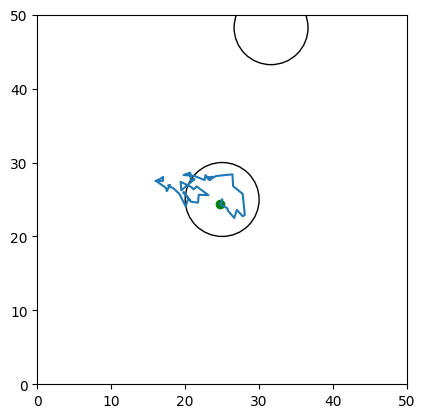

In [ ]:
#| hide
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()

ax.plot(pos[:,0], pos[:,1])
# ax.scatter(pos[phase == 0,0], pos[phase == 0,1], c = 'r')
# ax.scatter(pos[phase == 1,0], pos[phase == 1,1], c = 'g')
ax.scatter(pos[rewards == 1,0], pos[rewards == 1,1], c = 'g')

for tp in targets_pos:
    circle = patches.Circle(tp, radius=r, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(circle)

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_aspect('equal', 'box')

# Parallel training launchers

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()